<a href="https://colab.research.google.com/github/Mostafaali3/Machine_Learning_Project/blob/main/ECG_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [ ]:
# Load your dataset
df = pd.read_csv('/content/ecg_merged_features.csv')  # Adjust path

# Show info
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Drop duplicates
df = df.drop_duplicates()

# Drop constant features
df = df.loc[:, df.nunique() > 1]

# Drop features with >50% missing values (tweakable)
df = df.loc[:, df.isnull().mean() < 0.5]

# Optionally drop rows with any missing values
df = df.dropna()
df_features = df.drop(columns=['filename'], axis=1)
df_features.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 75 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             73 non-null     object 
 1   signal_length        72 non-null     float64
 2   signal_mean          72 non-null     float64
 3   signal_std           72 non-null     float64
 4   num_beats            72 non-null     float64
 5   rr_num_raw           72 non-null     float64
 6   rr_num_clean         72 non-null     float64
 7   rr_outliers_removed  72 non-null     float64
 8   mean_rr              72 non-null     float64
 9   median_rr            72 non-null     float64
 10  mode_rr              72 non-null     float64
 11  std_rr               72 non-null     float64
 12  iqr_rr               72 non-null     float64
 13  range_rr             72 non-null     float64
 14  min_rr               72 non-null     float64
 15  max_rr               72 non-null     float

Index(['signal_mean', 'signal_std', 'num_beats', 'rr_num_raw', 'rr_num_clean',
       'rr_outliers_removed', 'mean_rr', 'median_rr', 'mode_rr', 'std_rr',
       'iqr_rr', 'range_rr', 'min_rr', 'max_rr', 'p5_rr', 'p95_rr', 'mean_hr',
       'median_hr', 'hr_std', 'rmssd', 'nn50', 'pnn50', 'rr_prev_mean',
       'rr_post_mean', 'rr_ratio_mean', 'rr_local_mean', 'mean_qrs_width',
       'std_qrs_width', 'mean_qrs_amplitude', 'std_qrs_amplitude', 'PEAK_AMP',
       'PEAK_FREQ', 'BER_MAX', 'BER_MIN', 'BER_MEAN', 'BER_MEDIAN', 'BER_STD',
       'SC_MAX', 'SC_MIN', 'SC_MEAN', 'SC_MEDIAN', 'SC_STD', 'SB_MAX',
       'SB_MIN', 'SB_MEAN', 'SB_MEDIAN', 'SB_STD', 'MFCC_MAX', 'MFCC_MIN',
       'MFCC_MEAN', 'MFCC_MEDIAN', 'MFCC_STD', 'DELTA1_MAX', 'DELTA1_MIN',
       'DELTA1_MEAN', 'DELTA1_MEDIAN', 'DELTA1_STD', 'DELTA2_MAX',
       'DELTA2_MIN', 'DELTA2_MEAN', 'DELTA2_MEDIAN', 'DELTA2_STD', 'CA_MAX',
       'CA_MIN', 'CA_MEAN', 'CA_MEDIAN', 'CA_STD', 'CD_MAX', 'CD_MIN',
       'CD_MEAN', 'CD_MEDI

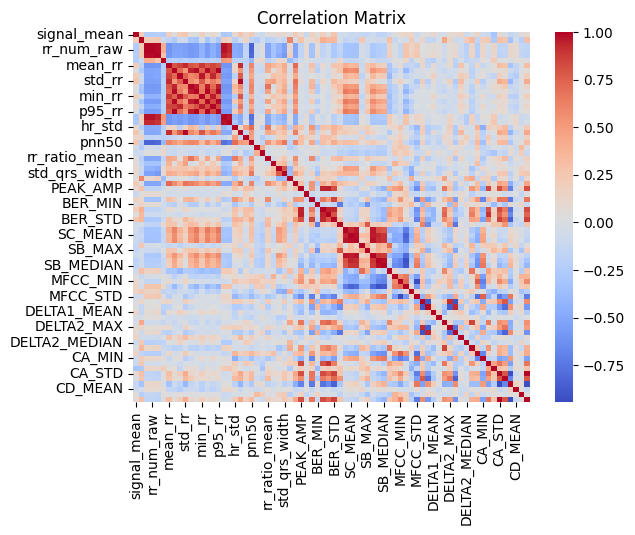

In [ ]:
# Pairplot or correlation heatmap
df_numeric = df_features.select_dtypes(include=[np.number])

sns.heatmap(df_numeric.corr(), cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Compute correlation matrix
corr_matrix = df_numeric.corr().abs()

# Mask the upper triangle (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all feature pairs with correlation > 0.9
high_corr = [(col1, col2, corr_matrix.loc[col1, col2])
             for col1 in upper.columns
             for col2 in upper.index
             if upper.loc[col2, col1] > 0.9]

# Print them
for col1, col2, corr in high_corr:
  if col1 != col2:
    print(f"{col1} and {col2} — correlation: {corr:.2f}")

rr_num_raw and num_beats — correlation: 1.00
rr_num_clean and num_beats — correlation: 0.99
rr_num_clean and rr_num_raw — correlation: 0.99
std_rr and mean_rr — correlation: 0.93
iqr_rr and median_rr — correlation: 0.94
range_rr and median_rr — correlation: 0.98
range_rr and iqr_rr — correlation: 0.96
min_rr and mode_rr — correlation: 0.97
max_rr and median_rr — correlation: 0.99
max_rr and iqr_rr — correlation: 0.96
max_rr and range_rr — correlation: 1.00
p5_rr and mode_rr — correlation: 0.93
p5_rr and min_rr — correlation: 0.96
p95_rr and median_rr — correlation: 0.99
p95_rr and iqr_rr — correlation: 0.95
p95_rr and range_rr — correlation: 1.00
p95_rr and max_rr — correlation: 1.00
mean_hr and num_beats — correlation: 0.97
mean_hr and rr_num_raw — correlation: 0.97
mean_hr and rr_num_clean — correlation: 0.94
median_hr and num_beats — correlation: 0.92
median_hr and rr_num_raw — correlation: 0.92
median_hr and mean_hr — correlation: 0.97
rmssd and mean_rr — correlation: 0.92
rmssd an

In [ ]:
# List of selected important features
selected_features = ['filename',
    'num_beats', 'mean_rr', 'median_rr', 'min_rr', 'mean_hr',
    'BER_MEAN', 'PEAK_AMP', 'SC_MEAN', 'SB_MIN', 'MFCC_MEAN',
    'MFCC_STD', 'DELTA1_MAX', 'DELTA1_MIN', 'CA_STD', 'CA_MEAN'
]

# Keep only these features
df_selected = df[selected_features].copy()

# Optional: confirm the shape and preview
print(f"Selected features shape: {df_selected.shape}")
df_selected.head()


Selected features shape: (71, 16)


,filename,num_beats,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,PEAK_AMP,SC_MEAN,SB_MIN,MFCC_MEAN,MFCC_STD,DELTA1_MAX,DELTA1_MIN,CA_STD,CA_MEAN
0,ECGPCG0001,557.0,430.345324,428.0,400.0,139.422916,4.962508e+04,13941.743650,145.299133,159.827694,-10.319570,141.094847,38.541074,-19.929848,0.000293,0.002518
1,ECGPCG0013,240.0,998.577406,988.0,704.0,60.085477,5.867246e+03,5214.782641,362.367643,255.657974,-21.244420,147.845407,7.185427,-6.442659,0.000244,0.003841
2,ECGPCG0019_1,223.0,707.135135,520.0,172.0,97.535934,3.004891e+06,616038.942631,138.243536,96.800204,-11.992825,104.087604,57.801303,-55.374610,0.002864,0.453754
3,ECGPCG0019_2,254.0,899.778656,512.0,204.0,108.301585,1.619758e+03,2334.177868,603.287716,453.742978,-26.453690,147.018597,58.607547,-60.304329,0.000569,0.001536
5,ECGPCG0019_4,6.0,29917.600000,28564.0,3788.0,2.005508,3.956700e+01,4028.702558,980.848027,991.449816,-33.454252,148.666526,2.872717,-3.914020,0.000329,0.002967


In [ ]:
selected_features = [
    'num_beats', 'mean_rr', 'median_rr', 'min_rr', 'mean_hr',
    'BER_MEAN', 'PEAK_AMP', 'SC_MEAN', 'SB_MIN', 'MFCC_MEAN',
    'MFCC_STD', 'DELTA1_MAX', 'DELTA1_MIN', 'CA_STD', 'CA_MEAN'
]

In [ ]:
df_labels = pd.read_csv('/content/stress_level_labels.csv')  # Adjust path

In [ ]:
df_labels.head()

,Record Name,Stress_Level
0,ECGPCG0001,High
1,ECGPCG0013,Rest
2,ECGPCG0019_1,Medium
3,ECGPCG0019_2,Medium
4,ECGPCG0019_3,Medium


In [ ]:
df_merged.head()

,filename,num_beats,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,PEAK_AMP,SC_MEAN,SB_MIN,MFCC_MEAN,MFCC_STD,DELTA1_MAX,DELTA1_MIN,CA_STD,CA_MEAN,Stress_Level
0,ECGPCG0001,557.0,430.345324,428.0,400.0,139.422916,4.962508e+04,13941.743650,145.299133,159.827694,-10.319570,141.094847,38.541074,-19.929848,0.000293,0.002518,High
1,ECGPCG0013,240.0,998.577406,988.0,704.0,60.085477,5.867246e+03,5214.782641,362.367643,255.657974,-21.244420,147.845407,7.185427,-6.442659,0.000244,0.003841,Rest
2,ECGPCG0019_1,223.0,707.135135,520.0,172.0,97.535934,3.004891e+06,616038.942631,138.243536,96.800204,-11.992825,104.087604,57.801303,-55.374610,0.002864,0.453754,Medium
3,ECGPCG0019_2,254.0,899.778656,512.0,204.0,108.301585,1.619758e+03,2334.177868,603.287716,453.742978,-26.453690,147.018597,58.607547,-60.304329,0.000569,0.001536,Medium
4,ECGPCG0019_4,6.0,29917.600000,28564.0,3788.0,2.005508,3.956700e+01,4028.702558,980.848027,991.449816,-33.454252,148.666526,2.872717,-3.914020,0.000329,0.002967,Medium


In [ ]:
df_merged = pd.merge(df_selected, df_labels, left_on='filename', right_on='Record Name', how='inner')

# Optional: drop the duplicate key column
df_merged.drop(columns=['Record Name'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Split features and labels
X = df_merged.drop(columns=['filename', 'Stress_Level'])  # Adjust 'label' if your label column has a different name
y = df_merged['Stress_Level']  # Assuming this is your target



In [ ]:
# Apply Gaussian (Yeo-Johnson) transformation
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pd.DataFrame(pt.fit_transform(X), columns=X.columns)


In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_transformed), columns=X.columns)


In [ ]:
# Example engineered features
X_scaled['rr_hr_ratio'] = X_scaled['mean_rr'] / (X_scaled['mean_hr'] + 1e-6)
X_scaled['beats_per_sec'] = X_scaled['num_beats'] / (X_scaled['mean_rr'] + 1e-6)


In [ ]:
selector = VarianceThreshold(threshold=0.01)  # remove near-constant features
X_selected = pd.DataFrame(selector.fit_transform(X_scaled), columns=X_scaled.columns[selector.get_support()])


In [ ]:
len(X_selected.columns)

17

In [ ]:
df_final = pd.concat([df_merged[['filename', 'Stress_Level']].reset_index(drop=True), X_selected], axis=1)
print(f"Final shape: {df_final.shape}")
df_final.head()

Final shape: (71, 19)


,filename,Stress_Level,num_beats,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,PEAK_AMP,SC_MEAN,SB_MIN,MFCC_MEAN,MFCC_STD,DELTA1_MAX,DELTA1_MIN,CA_STD,CA_MEAN,rr_hr_ratio,beats_per_sec
0,ECGPCG0001,High,1.255952,-1.262132,-1.012413,-0.283038,1.095497,0.238919,-0.298972,0.139208,-0.058125,0.212297,0.432133,0.932449,-0.045771,-0.811363,-0.054464,-1.152108,-0.995105
1,ECGPCG0013,Rest,-0.586236,0.633818,0.824434,0.948528,-0.776466,-0.990933,-1.789988,1.779670,1.096495,-1.578106,1.773573,-1.168201,1.262268,-1.424632,-0.005720,-0.816287,-0.924927
2,ECGPCG0019_1,Medium,-0.686779,0.041799,-0.435097,-3.406688,0.101033,3.409001,2.948762,0.020497,-2.106144,-0.099896,-2.292299,1.567865,-1.520349,2.273469,4.904619,0.413714,-16.429966
3,ECGPCG0019_2,Medium,-0.503620,0.476081,-0.476964,-2.609658,0.355515,-1.622785,-3.317661,2.362779,1.916665,-2.290002,1.585164,1.590528,-1.656205,1.160742,-0.091003,1.339129,-1.057843
4,ECGPCG0019_4,Medium,-2.011924,2.021610,2.130220,2.632806,-2.090038,-3.067063,-2.246903,2.770380,2.471667,-3.159403,1.968051,-1.967424,1.729337,-0.430280,-0.037856,-0.967260,-0.995208


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Step 1: Define X and y
X = df_merged.drop(columns=['filename', 'Stress_Level'])  # Adjust if your label column is named differently
y = df_merged['Stress_Level']

# Step 2: Train/test split (optional but recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Feature selection using model importance
selector = SelectFromModel(rf, prefit=True, threshold="median")  # keep top 50%
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Step 5: Create reduced DataFrame
df_selected = pd.concat([df_merged[['filename', 'Stress_Level']].reset_index(drop=True),
                         pd.DataFrame(X_selected, columns=selected_features)], axis=1)

# Preview
print(f"Selected features: {list(selected_features)}")
print(f"Final shape: {df_selected.shape}")
df_selected.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: ['mean_rr', 'median_rr', 'min_rr', 'mean_hr', 'BER_MEAN', 'SC_MEAN', 'SB_MIN', 'MFCC_MEAN']
Final shape: (71, 10)


,filename,Stress_Level,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,SC_MEAN,SB_MIN,MFCC_MEAN
0,ECGPCG0001,High,430.345324,428.0,400.0,139.422916,4.962508e+04,145.299133,159.827694,-10.319570
1,ECGPCG0013,Rest,998.577406,988.0,704.0,60.085477,5.867246e+03,362.367643,255.657974,-21.244420
2,ECGPCG0019_1,Medium,707.135135,520.0,172.0,97.535934,3.004891e+06,138.243536,96.800204,-11.992825
3,ECGPCG0019_2,Medium,899.778656,512.0,204.0,108.301585,1.619758e+03,603.287716,453.742978,-26.453690
4,ECGPCG0019_4,Medium,29917.600000,28564.0,3788.0,2.005508,3.956700e+01,980.848027,991.449816,-33.454252


In [ ]:
df_selected

,filename,Stress_Level,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,SC_MEAN,SB_MIN,MFCC_MEAN
0,ECGPCG0001,High,430.345324,428.0,400.0,139.422916,4.962508e+04,145.299133,159.827694,-10.319570
1,ECGPCG0013,Rest,998.577406,988.0,704.0,60.085477,5.867246e+03,362.367643,255.657974,-21.244420
2,ECGPCG0019_1,Medium,707.135135,520.0,172.0,97.535934,3.004891e+06,138.243536,96.800204,-11.992825
3,ECGPCG0019_2,Medium,899.778656,512.0,204.0,108.301585,1.619758e+03,603.287716,453.742978,-26.453690
4,ECGPCG0019_4,Medium,29917.600000,28564.0,3788.0,2.005508,3.956700e+01,980.848027,991.449816,-33.454252
...,...,...,...,...,...,...,...,...,...,...
66,ECGPCG0067,High,506.746269,416.0,380.0,140.337370,2.670688e+04,125.871766,165.102134,-9.263707
67,ECGPCG0066,High,731.411043,684.0,340.0,88.978186,1.234604e+05,87.095872,138.111339,-9.076179
68,ECGPCG0065,High,5605.485714,1400.0,340.0,33.736622,8.619467e+04,136.150736,138.067281,-11.389994
69,ECGPCG0069,High,10884.000000,8964.0,324.0,8.015199,1.933757e+05,141.564375,107.168904,-11.317392


,Stress_Level,filename,Stress_Level,mean_rr,median_rr,min_rr,mean_hr,BER_MEAN,SC_MEAN,SB_MIN,MFCC_MEAN
0,High,ECGPCG0001,High,430.345324,428.0,400.0,139.422916,4.962508e+04,145.299133,159.827694,-10.319570
1,Rest,ECGPCG0013,Rest,998.577406,988.0,704.0,60.085477,5.867246e+03,362.367643,255.657974,-21.244420
2,Medium,ECGPCG0019_1,Medium,707.135135,520.0,172.0,97.535934,3.004891e+06,138.243536,96.800204,-11.992825
3,Medium,ECGPCG0019_2,Medium,899.778656,512.0,204.0,108.301585,1.619758e+03,603.287716,453.742978,-26.453690
4,Medium,ECGPCG0019_4,Medium,29917.600000,28564.0,3788.0,2.005508,3.956700e+01,980.848027,991.449816,-33.454252
...,...,...,...,...,...,...,...,...,...,...,...
66,High,ECGPCG0067,High,506.746269,416.0,380.0,140.337370,2.670688e+04,125.871766,165.102134,-9.263707
67,High,ECGPCG0066,High,731.411043,684.0,340.0,88.978186,1.234604e+05,87.095872,138.111339,-9.076179
68,High,ECGPCG0065,High,5605.485714,1400.0,340.0,33.736622,8.619467e+04,136.150736,138.067281,-11.389994
69,High,ECGPCG0069,High,10884.000000,8964.0,324.0,8.015199,1.933757e+05,141.564375,107.168904,-11.317392


##ECG MODELS

In [ ]:
df_selected.to_csv('/content/ECG_final_selected_features_with_labels.csv', index=False)


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Prepare features and labels
X = df_selected.drop(columns=['filename', 'Stress_Level'])
y = df_selected['Stress_Level']

# 2. Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # HIGH, Medium, Low -> 0,1,2 (for example)

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# 4. Initialize and train the SVM model
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# 5. Predict on test set
y_pred = svm.predict(X_test)

# 6. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

        High       0.50      1.00      0.67        11
      Medium       0.00      0.00      0.00         7
        Rest       0.00      0.00      0.00         4

    accuracy                           0.50        22
   macro avg       0.17      0.33      0.22        22
weighted avg       0.25      0.50      0.33        22


Confusion Matrix:
 [[11  0  0]
 [ 7  0  0]
 [ 4  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare features and labels
X = df_selected.drop(columns=['filename', 'Stress_Level'])
y = df_selected['Stress_Level']

# Encode labels to numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6818181818181818

Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.91      0.87        11
      Medium       0.75      0.43      0.55         7
        Rest       0.33      0.50      0.40         4

    accuracy                           0.68        22
   macro avg       0.64      0.61      0.61        22
weighted avg       0.72      0.68      0.68        22


Confusion Matrix:
 [[10  0  1]
 [ 1  3  3]
 [ 1  1  2]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# # Prepare features and labels
# X = df_selected.drop(columns=['filename', 'label'])
# y = df_selected['label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize Logistic Regression (multinomial for multiclass)
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

        High       0.91      0.91      0.91        11
      Medium       0.75      0.43      0.55         7
        Rest       0.43      0.75      0.55         4

    accuracy                           0.73        22
   macro avg       0.70      0.70      0.67        22
weighted avg       0.77      0.73      0.73        22


Confusion Matrix:
 [[10  0  1]
 [ 1  3  3]
 [ 0  1  3]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_test_aligned = X_test[X_train.columns]

# Initialize and train Gradient Boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

# Predict and evaluate
y_pred = gbc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7727272727272727

Classification Report:
               precision    recall  f1-score   support

        High       0.90      0.82      0.86        11
      Medium       0.60      0.86      0.71         7
        Rest       1.00      0.50      0.67         4

    accuracy                           0.77        22
   macro avg       0.83      0.73      0.74        22
weighted avg       0.82      0.77      0.77        22


Confusion Matrix:
 [[9 2 0]
 [1 6 0]
 [0 2 2]]


##OLD PCG MODEL (acc was increased in another notebook)

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the data (adjust file paths if needed)
X_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_X.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_y.csv').squeeze()  # squeeze() if single column dataframe
y_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_y.csv').squeeze()

X_test = X_test[X_train.columns]


# If labels are categorical strings, encode them
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbc.fit(X_train, y_train_encoded)

# Predict on test data
y_pred = gbc.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.25      1.00      0.40         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.08      0.33      0.13         8
weighted avg       0.06      0.25      0.10         8


Confusion Matrix:
 [[0 4 0]
 [0 2 0]
 [0 2 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_X.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_y.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_y.csv').squeeze()

# Align columns between train and test
X_test = X_test[X_train.columns]

# Encode string labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr.fit(X_train, y_train_encoded)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.25      1.00      0.40         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.08      0.33      0.13         8
weighted avg       0.06      0.25      0.10         8


Confusion Matrix:
 [[0 4 0]
 [0 2 0]
 [0 2 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_X.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_y.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_y.csv').squeeze()

# Align columns
X_test = X_test[X_train.columns]

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train
dt.fit(X_train, y_train_encoded)

# Predict
y_pred = dt.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

        High       0.50      1.00      0.67         4
      Medium       0.00      0.00      0.00         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8


Confusion Matrix:
 [[4 0 0]
 [2 0 0]
 [2 0 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_X.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_y.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_y.csv').squeeze()

# Align columns
X_test = X_test[X_train.columns]

# Normalize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize and train SVM
svm = SVC(kernel='poly', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train_encoded)

# Predict
y_pred = svm.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.25      1.00      0.40         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.08      0.33      0.13         8
weighted avg       0.06      0.25      0.10         8


Confusion Matrix:
 [[0 4 0]
 [0 2 0]
 [0 2 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_X.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Train_pcg_y.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/Test_pcg_y.csv').squeeze()

# Ensure columns match
X_test = X_test[X_train.columns]

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_encoded)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.33      1.00      0.50         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.11      0.33      0.17         8
weighted avg       0.08      0.25      0.12         8


Confusion Matrix:
 [[0 2 2]
 [0 2 0]
 [0 2 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Optional: train/test split if needed
# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 1: Fit Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Step 2: Feature selection using model importance
selector = SelectFromModel(gb, prefit=True, threshold="median")  # keep top 50%
X_selected = selector.transform(X_train)
selected_features = X_train.columns[selector.get_support()]

# Step 3: Preview selected features
print(f"Selected features: {list(selected_features)}")



Selected features: ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
X_train.columns

Index(['MEAN', 'STD', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MAX', 'SB_MEAN',
       'SB_STD', 'DELTA1_STD', 'DELTA2_MEDIAN', 'CA_MEAN', 'CD_MIN', 'CD_MEAN',
       'CD_MEDIAN'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/pcg_features_With_stress_level.csv')
# 1. Prepare features and labels
X = data.drop(columns=[ 'Stress_Level'])
y = data['Stress_Level']

# 2. Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # HIGH, Medium, Low -> 0,1,2 (for example)

# 3. Split into train and test sets

# Use only specific features
selected_features =  ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
X= X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)



# Encode labels

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6818181818181818

Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.70      0.70        10
      Medium       0.56      0.62      0.59         8
        Rest       1.00      0.75      0.86         4

    accuracy                           0.68        22
   macro avg       0.75      0.69      0.72        22
weighted avg       0.70      0.68      0.69        22


Confusion Matrix:
 [[7 3 0]
 [3 5 0]
 [0 1 3]]


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/pcg_features_With_stress_level.csv')

# Prepare features and labels
X = data.drop(columns=['Stress_Level'])
y = data['Stress_Level']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use only specific features
selected_features = ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
X = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Training and evaluation
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== Random Forest ===
Accuracy: 0.6818181818181818
Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.70      0.70        10
      Medium       0.56      0.62      0.59         8
        Rest       1.00      0.75      0.86         4

    accuracy                           0.68        22
   macro avg       0.75      0.69      0.72        22
weighted avg       0.70      0.68      0.69        22

Confusion Matrix:
 [[7 3 0]
 [3 5 0]
 [0 1 3]]

=== Logistic Regression ===
Accuracy: 0.5909090909090909
Classification Report:
               precision    recall  f1-score   support

        High       0.56      0.90      0.69        10
      Medium       0.67      0.50      0.57         8
        Rest       0.00      0.00      0.00         4

    accuracy                           0.59        22
   macro avg       0.41      0.47      0.42        22
weighted avg       0.50      0.59      0.52        22

Confusion Matrix:
 [[9 1 0]
 [4 4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.6363636363636364
Classification Report:
               precision    recall  f1-score   support

        High       0.67      0.80      0.73        10
      Medium       0.50      0.38      0.43         8
        Rest       0.75      0.75      0.75         4

    accuracy                           0.64        22
   macro avg       0.64      0.64      0.64        22
weighted avg       0.62      0.64      0.62        22

Confusion Matrix:
 [[8 2 0]
 [4 3 1]
 [0 1 3]]


In [ ]:
selected_features = ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
data = data[selected_features]

# Save selected features to CSV
X.to_csv('/content/drive/MyDrive/data/MachineLearning_Project/pcg_selected_features.csv', index=False)

##MULTIMODAL MODELS

In [ ]:
import pandas as pd

import pandas as pd

# Load the data
df_selected = pd.read_csv('/content/ECG_final_selected_features_with_labels.csv')  # 'file_name'
df_pcg = pd.read_csv('/content/drive/MyDrive/data/MachineLearning_Project/pcg_features_with_record_name.csv')  # 'record_name'

# Rename ECG columns (except 'file_name')
df_selected = df_selected.rename(columns={
    col: f'ecg_{col}' if col != 'filename' else col for col in df_selected.columns
})

# Rename PCG columns (except 'record_name')
df_pcg = df_pcg.rename(columns={
    col: f'pcg_{col}' if col != 'RECORD_NAME' else col for col in df_pcg.columns
})

# Preview the updated column names
print("ECG Columns:", df_selected.columns.tolist())
print("PCG Columns:", df_pcg.columns.tolist())

# Merge using different column names
merged_df = pd.merge(df_selected, df_pcg, left_on='filename', right_on='RECORD_NAME')

# Save the merged DataFrame
# merged_df.to_csv('/content/drive/MyDrive/data/merged_pcg_features.csv', index=False)



ECG Columns: ['filename', 'ecg_Stress_Level', 'ecg_mean_rr', 'ecg_median_rr', 'ecg_min_rr', 'ecg_mean_hr', 'ecg_BER_MEAN', 'ecg_SC_MEAN', 'ecg_SB_MIN', 'ecg_MFCC_MEAN']
PCG Columns: ['pcg_MAX', 'pcg_MIN', 'pcg_MEAN', 'pcg_MEDIAN', 'pcg_STD', 'pcg_ENERGY', 'pcg_POWER', 'pcg_AE_MAX', 'pcg_AE_MIN', 'pcg_AE_MEAN', 'pcg_AE_MEDIAN', 'pcg_AE_STD', 'pcg_RM_MAX', 'pcg_RM_MIN', 'pcg_RM_MEAN', 'pcg_RM_MEDIAN', 'pcg_RM_STD', 'pcg_ZCR_MAX', 'pcg_ZCR_MIN', 'pcg_ZCR_MEAN', 'pcg_ZCR_MEDIAN', 'pcg_ZCR_STD', 'pcg_ZCR_GLOBAL', 'pcg_PEAK_AMP', 'pcg_PEAK_FREQ', 'pcg_BER_MAX', 'pcg_BER_MIN', 'pcg_BER_MEAN', 'pcg_BER_MEDIAN', 'pcg_BER_STD', 'pcg_SC_MAX', 'pcg_SC_MIN', 'pcg_SC_MEAN', 'pcg_SC_MEDIAN', 'pcg_SC_STD', 'pcg_SB_MAX', 'pcg_SB_MIN', 'pcg_SB_MEAN', 'pcg_SB_MEDIAN', 'pcg_SB_STD', 'pcg_MFCC_MAX', 'pcg_MFCC_MIN', 'pcg_MFCC_MEAN', 'pcg_MFCC_MEDIAN', 'pcg_MFCC_STD', 'pcg_DELTA1_MAX', 'pcg_DELTA1_MIN', 'pcg_DELTA1_MEAN', 'pcg_DELTA1_MEDIAN', 'pcg_DELTA1_STD', 'pcg_DELTA2_MAX', 'pcg_DELTA2_MIN', 'pcg_DELTA2_

In [ ]:
merged_df.columns

Index(['filename', 'ecg_Stress_Level', 'ecg_mean_rr', 'ecg_median_rr',
       'ecg_min_rr', 'ecg_mean_hr', 'ecg_BER_MEAN', 'ecg_SC_MEAN',
       'ecg_SB_MIN', 'ecg_MFCC_MEAN', 'pcg_MAX', 'pcg_MIN', 'pcg_MEAN',
       'pcg_MEDIAN', 'pcg_STD', 'pcg_ENERGY', 'pcg_POWER', 'pcg_AE_MAX',
       'pcg_AE_MIN', 'pcg_AE_MEAN', 'pcg_AE_MEDIAN', 'pcg_AE_STD',
       'pcg_RM_MAX', 'pcg_RM_MIN', 'pcg_RM_MEAN', 'pcg_RM_MEDIAN',
       'pcg_RM_STD', 'pcg_ZCR_MAX', 'pcg_ZCR_MIN', 'pcg_ZCR_MEAN',
       'pcg_ZCR_MEDIAN', 'pcg_ZCR_STD', 'pcg_ZCR_GLOBAL', 'pcg_PEAK_AMP',
       'pcg_PEAK_FREQ', 'pcg_BER_MAX', 'pcg_BER_MIN', 'pcg_BER_MEAN',
       'pcg_BER_MEDIAN', 'pcg_BER_STD', 'pcg_SC_MAX', 'pcg_SC_MIN',
       'pcg_SC_MEAN', 'pcg_SC_MEDIAN', 'pcg_SC_STD', 'pcg_SB_MAX',
       'pcg_SB_MIN', 'pcg_SB_MEAN', 'pcg_SB_MEDIAN', 'pcg_SB_STD',
       'pcg_MFCC_MAX', 'pcg_MFCC_MIN', 'pcg_MFCC_MEAN', 'pcg_MFCC_MEDIAN',
       'pcg_MFCC_STD', 'pcg_DELTA1_MAX', 'pcg_DELTA1_MIN', 'pcg_DELTA1_MEAN',
       'pcg_DELTA

In [ ]:
import pandas as pd

# Load your dataset

# Always include these
base_features = ['filename', 'Stress_Level']

# Define two sets of desired features
selected_features_1 = ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
selected_features_2 = [
    'num_beats', 'mean_rr', 'median_rr', 'min_rr', 'mean_hr',
    'BER_MEAN', 'PEAK_AMP', 'SC_MEAN', 'SB_MIN', 'MFCC_MEAN',
    'MFCC_STD', 'DELTA1_MAX', 'DELTA1_MIN', 'CA_STD', 'CA_MEAN'
]

# Combine and deduplicate


# Subset and save
df_selected = merged_df[final_columns]
df_selected.to_csv('/content/drive/MyDrive/data/ecg_pcg_final_selected_features.csv', index=False)

print("Saved final selected features with filename and stress label.")


Saved final selected features with filename and stress label.


In [ ]:
df_selected.columns

Index(['CA_STD', 'mean_rr', 'median_rr', 'ZCR_GLOBAL', 'SB_MIN_x',
       'DELTA1_MIN', 'mean_hr', 'MEAN', 'PEAK_AMP', 'MFCC_MEAN_x', 'CD_MEDIAN',
       'RM_MIN', 'SB_MEAN', 'MFCC_STD', 'CA_MEAN', 'Stress_Level',
       'DELTA1_MAX', 'BER_MEAN_x', 'min_rr', 'SC_MEAN_x'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# 1. Load merged dataset
df = merged_df

# 2. Drop filename (not a feature), extract label
X = df.drop(columns=['filename', 'ecg_Stress_Level', 'RECORD_NAME'])
y = df['ecg_Stress_Level']

# 3. Encode the label if it's string-based
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# 5. Apply Gradient Boosting for feature importance
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# 6. Feature selection (Warber)
selector = SelectFromModel(gb, prefit=True, threshold="mean")  # Select features > mean importance
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# 7. Train again with reduced features
gb_reduced = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_reduced.fit(X_train_reduced, y_train)
y_pred = gb_reduced.predict(X_test_reduced)

# 8. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 9. Optional: See which features were selected
selected_features = X.columns[selector.get_support()]
print("\nSelected Features:\n", selected_features.tolist())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.91      0.87        11
      Medium       0.44      0.57      0.50         7
        Rest       0.00      0.00      0.00         4

    accuracy                           0.64        22
   macro avg       0.43      0.49      0.46        22
weighted avg       0.56      0.64      0.59        22


Selected Features:
 ['ecg_mean_rr', 'ecg_median_rr', 'ecg_min_rr', 'ecg_SC_MEAN', 'pcg_POWER', 'pcg_PEAK_FREQ', 'pcg_BER_MIN', 'pcg_BER_MEAN', 'pcg_BER_STD', 'pcg_SB_MEAN', 'pcg_SB_MEDIAN', 'pcg_DELTA1_MAX', 'pcg_DELTA1_MEDIAN', 'pcg_DELTA2_MEAN']


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

df = merged_df

# 2. Drop filename (not a feature), extract label
X = df.drop(columns=['filename', 'ecg_Stress_Level', 'RECORD_NAME'])
y = df['ecg_Stress_Level']

# 2. Define selected features and target
selected_features = [
    'ecg_mean_rr', 'ecg_median_rr', 'ecg_min_rr', 'ecg_SC_MEAN',
    'pcg_POWER', 'pcg_PEAK_FREQ', 'pcg_BER_MIN', 'pcg_BER_MEAN',
    'pcg_BER_STD', 'pcg_SB_MEAN', 'pcg_SB_MEDIAN',
    'pcg_DELTA1_MAX', 'pcg_DELTA1_MEDIAN', 'pcg_DELTA2_MEAN'
]
X = df[selected_features]
y = df['ecg_Stress_Level']

# 3. Encode labels if needed
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 5. Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Random Forest Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.91      0.87        11
      Medium       0.50      0.29      0.36         7
        Rest       0.33      0.50      0.40         4

    accuracy                           0.64        22
   macro avg       0.56      0.56      0.54        22
weighted avg       0.64      0.64      0.62        22



In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Use your already merged dataframe
df = merged_df

# Selected features and target
selected_features = [
    'ecg_mean_rr', 'ecg_median_rr', 'ecg_min_rr', 'ecg_SC_MEAN',
    'pcg_POWER', 'pcg_PEAK_FREQ', 'pcg_BER_MIN', 'pcg_BER_MEAN',
    'pcg_BER_STD', 'pcg_SB_MEAN', 'pcg_SB_MEDIAN',
    'pcg_DELTA1_MAX', 'pcg_DELTA1_MEDIAN', 'pcg_DELTA2_MEAN'
]
X = df[selected_features]
y = df['ecg_Stress_Level']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Logistic Regression Accuracy: 0.5909090909090909

Classification Report:
               precision    recall  f1-score   support

        High       0.73      1.00      0.85        11
      Medium       0.33      0.29      0.31         7
        Rest       0.00      0.00      0.00         4

    accuracy                           0.59        22
   macro avg       0.36      0.43      0.38        22
weighted avg       0.47      0.59      0.52        22



In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.91      0.87        11
      Medium       0.50      0.43      0.46         7
        Rest       0.25      0.25      0.25         4

    accuracy                           0.64        22
   macro avg       0.53      0.53      0.53        22
weighted avg       0.62      0.64      0.63        22



In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 14
[LightGBM] [Info] Start training from score -0.756326
[LightGBM] [Info] Start training from score -1.119232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
dt = DecisionTreeClassifier(random_state=42)

# Train
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, target_names=le.classes_))


Decision Tree Accuracy: 0.5454545454545454

Classification Report:
               precision    recall  f1-score   support

        High       0.64      0.82      0.72        11
      Medium       0.33      0.29      0.31         7
        Rest       0.50      0.25      0.33         4

    accuracy                           0.55        22
   macro avg       0.49      0.45      0.45        22
weighted avg       0.52      0.55      0.52        22

